In [3]:
%load_ext autoreload
%autoreload 2

In [23]:
import sys
sys.path.append("../src")

from vidtoseg import r2plus1d, simsiam, unet
from data import LabeledDataset, unnormalize

import torch

In [5]:
dataset = LabeledDataset("../Dataset_Student")
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, num_workers=2)

In [27]:
vid, masks = dataset[0]

x = vid[:11].transpose(0, 1).unsqueeze(0)

print(x.shape)

backbone = r2plus1d.R2Plus1DNet()
output = backbone(x)

torch.Size([1, 3, 11, 256, 256])


Sizes of each layer output
```
torch.Size([1, 3, 11, 256, 256])
torch.Size([1, 32, 11, 128, 128])
torch.Size([1, 32, 11, 128, 128])
torch.Size([1, 64, 6, 64, 64])
torch.Size([1, 128, 3, 32, 32])
torch.Size([1, 256, 2, 16, 16])
```

In [9]:
sum(p.numel() for p in backbone.parameters() if p.requires_grad)

NameError: name 'backbone' is not defined

In [6]:
ssl_model = simsiam.SimSiamGSTA()
sum(p.numel() for p in ssl_model.parameters() if p.requires_grad)

19714087

In [7]:
vid, masks = next(iter(dataloader))

x = vid.transpose(1, 2)
x1, x2 = x[:,:,:11], x[:,:,11:]

# with torch.no_grad():
#     res = ssl_model(x1, x2)

In [11]:
model = unet.UNetVidToSeg(ssl_model)
sum(p.numel() for p in model.parameters() if p.requires_grad)

22041048

In [15]:
res = model(x1)

5
0
x after block 0 torch.Size([2, 32, 11, 128, 128])
5
1
x after block 1 torch.Size([2, 32, 11, 128, 128])
5
2
x after block 2 torch.Size([2, 64, 6, 64, 64])
5
3
x after block 3 torch.Size([2, 128, 3, 32, 32])
5
4
torch.Size([2, 160, 128, 128])
torch.Size([2, 160, 128, 128])
torch.Size([2, 128, 64, 64])
torch.Size([2, 256, 32, 32])
torch.Size([2, 256, 2, 16, 16])
Up block 0:
torch.Size([2, 512, 16, 16])
torch.Size([2, 256, 32, 32])
Up block 1:
torch.Size([2, 256, 32, 32])
torch.Size([2, 128, 64, 64])
Up block 2:
torch.Size([2, 128, 64, 64])
torch.Size([2, 160, 128, 128])
Up block 3:
torch.Size([2, 128, 128, 128])
torch.Size([2, 160, 128, 128])


In [16]:
print(res.shape)

torch.Size([2, 49, 160, 240])


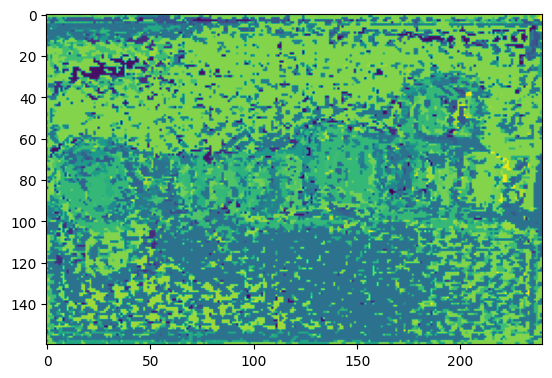

In [24]:
import matplotlib.pyplot as plt

plt.imshow(torch.argmax(res[0], dim=0))

torch.Size([2, 3, 22, 256, 256])
torch.Size([22, 3, 256, 256])


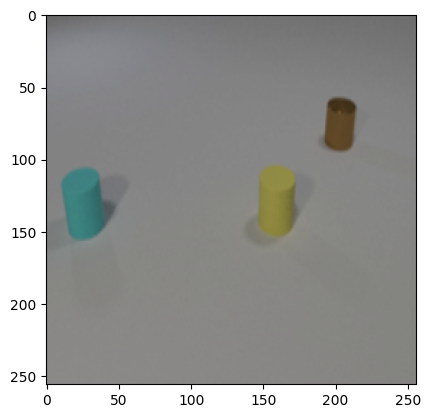

In [34]:
print(x.shape)
image = unnormalize(x[0].transpose(0, 1))
print(image.shape)
plt.imshow(image.movedim(1, -1)[0])